# CART Decision Tree Regression
<br/>

CART (Classification and Regression Trees) is a decision tree algorithm that uses the **mean squared error (MSE) criterion** for regression tasks, splitting data recursively to minimize variance within nodes. It produces a binary tree where each split is based on the best threshold of a feature.
***
## Loading the dataset

In [1]:
import pandas as pd

df_csv = pd.read_csv('Student_Performance.csv')
df_csv.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


## Cleaning the data

In [2]:
df_csv["Extracurricular Activities"] = df_csv["Extracurricular Activities"].map({'Yes': 1, 'No': 0})
df_csv.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


## Determining the quality of a split
- After we split the dataset, we calculate the variance of the target value in each split.
- Let $n_1$ and $n_2$ be the number of values in split-1 and split-2 respectively.

$\therefore$ The error becomes $=\displaystyle\frac{n_1\times Var(\text{Split-1}) + n_2\times Var(\text{Split-2})}{n_1+n_2}$
## Algorithm to find the best feature and threshold for splitting the dataset
- Initialize 3 variables: $\text{feature} = 0$, $\text{threshold} = 0$ and $\text{error} = \infty$.
- Iterate throguh all the features. For every feature $f_i$:
    - For every unique value $v_i$ of the feature $f_i$, divide the target dataset into 2 parts:
        - **Split-1:** Target values for which $f_i\leq v_i$.
        - **Split-2:** Target values for which $f_i> v_i$.
    - Calculate the quality (error) of the split using the formula given above.
    - If error $<$ the previously assigned value, set $\text{feature} = i$, $\text{threshold} = v_i$ and error $=$ newly calculated error.
    - Return the tuple `(feature, threshold, error)`.

**Note:** $\text{MSE=Variance+Bias}^2$ but since bias is 0 in our case, we can use the terms MSE and variance interchangeably.
***
## Implementing the splitting algorithm

In [3]:
from typing import Tuple, Optional
import numpy as np
import numpy.typing as npt

# Mean Squared Error (used for splitting criterion)
def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

def best_split(
    X: npt.NDArray[np.float64], 
    y: npt.NDArray[np.float64]
) -> Tuple[Optional[int], Optional[float], float]:
    """
    Find the best feature and threshold to split the data.

    Parameters:
        X: 2D NumPy array of shape (n_samples, n_features)
        y: 1D NumPy array of shape (n_samples,)

    Returns:
        best_feature: Index of the feature to split on (or None if no split)
        best_thresh: Threshold value for the split (or None if no split)
        best_mse: Mean squared error of the best split
    """

    best_feature, best_thresh, best_mse = None, None, float("inf")
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for thresh in thresholds:
            left_bitmask = X[:, feature] <= thresh
            right_bitmask = X[:, feature] > thresh

            if len(y[left_bitmask]) == 0 or len(y[right_bitmask]) == 0:
                continue

            mse_left = mse(y[left_bitmask])
            mse_right = mse(y[right_bitmask])
            weighted_mse = (len(y[left_bitmask]) * mse_left + len(y[right_bitmask]) * mse_right) / len(y)

            if weighted_mse < best_mse:
                best_feature, best_thresh, best_mse = feature, thresh, weighted_mse

    return best_feature, best_thresh, best_mse

## Separating target-feature and non-target features

In [4]:
target_feature = df_csv["Performance Index"]
df_csv = df_csv.drop("Performance Index", axis = 1)

## Defining the Node class for the Decision Tree
Each node contains:
- The feature used for splitting.
- Threshold value of that feature.
- Pointer to the left-subtree (where value of the feature $\leq$ threshold value).
- Pointer to the right-subtree (where value of the feature $>$ threshold value).
***

In [5]:
headers = list(df_csv.columns.values)

class Node:
    def __init__(self,
             feature_: int, threshold_: float,
             left_subtree_, right_subtree_):
        self.feature = feature_; self.threshold = threshold_
        self.left_subtree = left_subtree_; self.right_subtree = right_subtree_

    def __str__(self):
        return f"{headers[self.feature]} : {self.threshold: .2f}"

## Hyper-parameters used
- **max_depth**: Maximum-depth of the decision tree.
- **min_samples_split**: Minimum number of values present in the split to consider splitting further.
## Algorithm to create the decision tree
- Split the dataset into `Split-1` and `Split-2`.
- Create the left-subtree by further splitting `Split-1`.
- Create the right-subtree by further splitting `Split-2`.
- If base condition is reached, store the mean of the current split as the leaf node. Base condition:
    - `max_depth` of the decision tree is reached.
    - Number of values in the split $<$ `min_samples_split`.
    - The split has only 1 unique value of the target feature, i.e, all the values are the same.
***
## Implementing the decision tree

In [6]:
from typing import Tuple, Optional
import numpy as np
import numpy.typing as npt

class RegressionTree:
    def __init__(self, max_depth = 5, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self,
            X: npt.NDArray[np.float64], 
            y: npt.NDArray[np.float64], depth_ = 0):
        if depth_ >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:
            return np.mean(y)

        feature, thresh, error = best_split(X, y)
        if feature is None:
            return np.mean(y)

        left_bitmask = X[:, feature] <= thresh
        right_bitmask = X[:, feature] > thresh

        left_subtree = self.fit(X[left_bitmask], y[left_bitmask], depth_ + 1)
        right_subtree = self.fit(X[right_bitmask], y[right_bitmask], depth_ + 1)

        return Node(feature, thresh, left_subtree, right_subtree)

    def train(self,
              X: npt.NDArray[np.float64], y: npt.NDArray[np.float64]):
        self.tree = self.fit(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, Node):  # leaf node
            return node
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left_subtree)
        else:
            return self.predict_one(x, node.right_subtree)

    def predict(self, X):
        return np.array([self.predict_one(sample, self.tree) for sample in X])

## Code to visualize the Decision Tree

In [7]:
from graphviz import Digraph
from IPython.display import display

def add_nodes_edges(dot: Digraph, node: Node, parent: Node = None, edge_label: str = ""):
    """
    Recursively add nodes and edges from your custom Node class to a Graphviz Digraph.
    """
    if node is None:
        return

    # Node label (leaf or split)
    if not isinstance(node, Node):
        label = f"Leaf\nValue: {node:.2f}"  # leaf node
        fillcolor = "lightgreen"
    else:
        label = str(node)  # uses Node.__str__()
        fillcolor = "lightblue"

    # Add the node
    dot.node(str(id(node)), label, shape = "box", style = "filled", fillcolor = fillcolor)

    # Add edge from parent
    if parent is not None:
        dot.edge(str(id(parent)), str(id(node)), label=edge_label)

    # Recurse left and right
    if isinstance(node, Node):
        add_nodes_edges(dot, node.left_subtree, node, "<=")
        add_nodes_edges(dot, node.right_subtree, node, ">")

def visualize_tree_inline(root: Node):
    """
    Visualize a decision tree inline in Jupyter Notebook.
    """
    dot = Digraph()
    dot.attr(rankdir = "TB")   # top-to-bottom orientation
    dot.attr(ranksep = "0.5")  # reduce vertical spacing
    dot.attr(nodesep = "0.3")  # reduce horizontal spacing

    add_nodes_edges(dot, root)
    display(dot)  # show directly in Jupyter

## Splitting the dataset into training and testing parts

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_csv, target_feature, test_size=0.2, random_state=42
)

## Driver code

In [9]:
regressor1 = RegressionTree(max_depth = 5)
regressor1.train(X_train.to_numpy(), y_train.to_numpy())

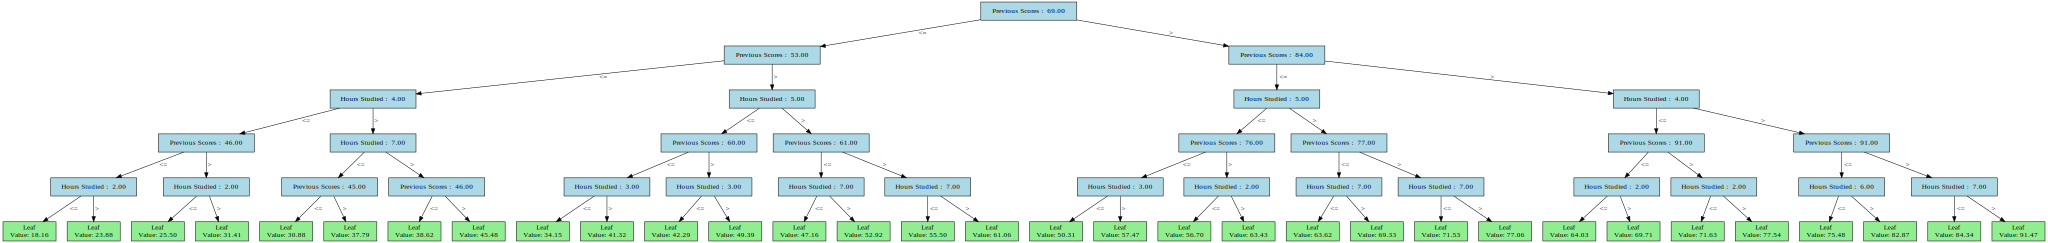

In [10]:
visualize_tree_inline(regressor1.tree)

In [11]:
y_pred_1 = list(regressor1.predict(X_test.to_numpy()))
y_pred_1 = np.array(y_pred_1)
y_pred_1

array([49.39370079, 18.1641791 , 47.16287879, ..., 18.1641791 ,
       63.43490305, 41.31683168])

## Calculating the error

In [12]:
mse_value = np.mean((y_test - y_pred_1) ** 2)
print("Test MSE:", mse_value)

Test MSE: 12.987047842797772


## Implementing Decision Tree using Scikit-learn

In [13]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

regressor2 = DecisionTreeRegressor(max_depth = 5)
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [14]:
y_pred_2 = regressor2.predict(X_test)
y_pred_2

array([49.39370079, 18.1641791 , 47.16287879, ..., 18.1641791 ,
       63.43490305, 41.31683168])

## Calculating the error

In [15]:
mse_value2 = np.mean((y_test - y_pred_2) ** 2)
print("Test MSE:", mse_value2)

Test MSE: 12.987047842797772


## Comparing the models

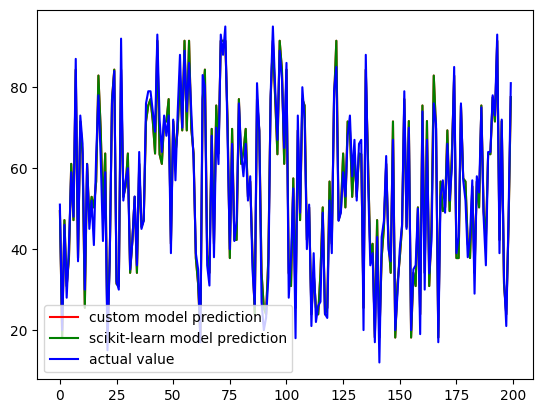

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

start, end = 0, 200
x_range = list(range(len(y_test[start: end])))

plt.plot(x_range, y_pred_1[start: end], color = 'red', label = 'custom model prediction')
plt.plot(x_range, y_pred_2[start: end], color = 'green', label = 'scikit-learn model prediction')
plt.plot(x_range, y_test[start: end], color = 'blue', label = 'actual value')
plt.legend(loc="lower left")
plt.show()

***